In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import math

import torch.optim as optim
import numpy as np
from tqdm import trange
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

from mmnn import MMNN_UQ,SinTu
from data_sets.generate_data_sets import TestFunctions


from UQ import NN_UQ

plt.style.use('figures/images_style.mplstyle')

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

/work/Sebas/MMNN/data_sets/generate_data_sets.py:48: SyntaxWarning: invalid escape sequence '\C'
  f2: Non-smooth oscillatory function (C⁰\C¹)
/work/Sebas/MMNN/data_sets/generate_data_sets.py:63: SyntaxWarning: invalid escape sequence '\C'
  f3: Another non-smooth oscillatory function (C⁰\C¹)


In [2]:
device

device(type='cuda', index=3)

In [3]:
f1 = TestFunctions.f2_nonsmooth_oscillatory

In [4]:
func = lambda x: torch.cos(20*torch.pi*torch.abs(x)**(1.4))+0.5*torch.cos(12*torch.pi*torch.abs(x)**(1.6))
# func = lambda x: torch.sin(5 * np.pi * x)  # Simpler function for testing
# Quick integration test

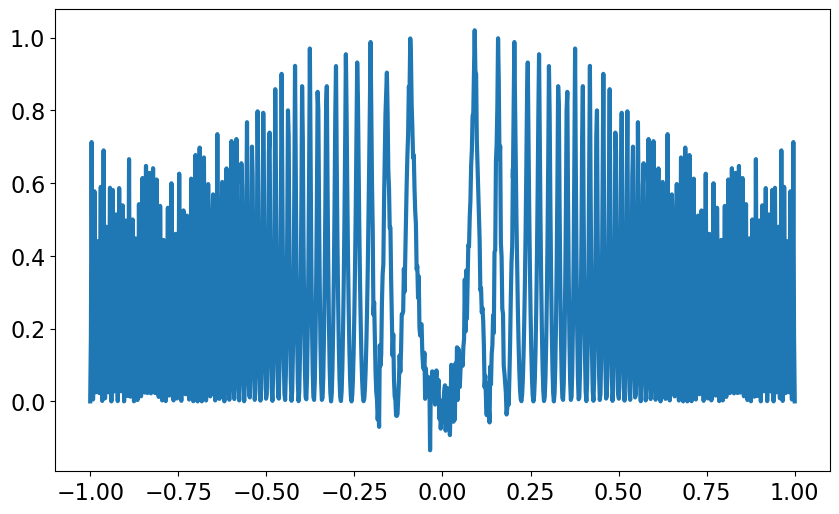

In [25]:
torch.manual_seed(0)
x_train_no_noise = torch.cat([
    torch.linspace(-1, -0.2, 400),
    torch.linspace(0.2, 1, 400)
]).to(device)
y_train_no_noise = f1(x_train_no_noise) 


x_train_noise = torch.linspace(-.2,.2, 200).to(device)
y_train_noise = f1(x_train_noise) + 0.05 * torch.randn_like(x_train_noise)    

x_train = torch.cat([x_train_no_noise, x_train_noise], dim=0).to(device)
x_argsort = torch.argsort(x_train, dim=0)
x_train = x_train[x_argsort].unsqueeze(1)
y_train = torch.cat([y_train_no_noise, y_train_noise], dim=0).to(device)
y_train = y_train[x_argsort].unsqueeze(1)
plt.figure(figsize=(10,6))
plt.plot(x_train.cpu(), y_train.cpu(), label='Train')
plt.show()

x_val = torch.linspace(-1.2, 1.2, 500).to(device)
# y_val = func(2 * np.pi * x_val) + 0.000 * torch.randn_like(x_val)
y_val = f1(x_val) + 0.0 * torch.randn_like(x_val)

# Data loaders
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=100)

In [33]:
model = MMNN_UQ(
    ranks = [1]+[36]*5+[1],
    widths = [366]*6,
    device  = device,
    n_gaussian_layers=2,
    sigma=0.05,
    fixWb=True
)

# model = MMNN(
#     ranks = [1]+[36]*5+[1],
#     widths = [366]*6,
#     device  = device,
#     fixWb=True
# )

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
loss_fn = nn.MSELoss()

MMNN_UQ Configuration:
  Total W,b layers: 6
  Gaussian W,b layers: 2
  Gaussian layer indices: [4, 5]
  Creating Gaussian sampler for layer 4 (fcs[8])
  Creating Gaussian sampler for layer 5 (fcs[10])
  Total samplers created: 2


In [34]:
# Training 

losses = []
batch_size = 500
num_epochs = 1000


In [35]:
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch_x,batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = loss_fn(preds, batch_y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    scheduler.step()
    mean_epoch_loss = np.mean(epoch_losses)
    losses.append(mean_epoch_loss)
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {mean_epoch_loss:.4f}")
        

Epoch 0, Loss: 0.0844
Epoch 200, Loss: 0.0063
Epoch 400, Loss: 0.0034
Epoch 600, Loss: 0.0020
Epoch 800, Loss: 0.0011


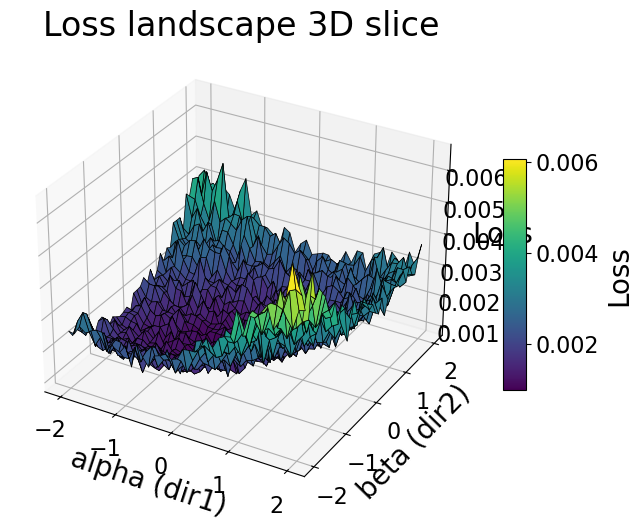

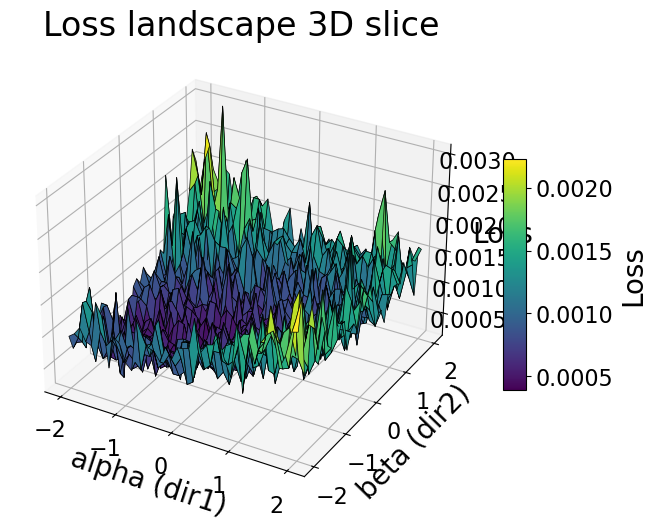

In [36]:
import numpy as np

# --- LOSS LANDSCAPE 2D VISUALIZATION ---

def get_trainable_params(model):
    """Return a flattened vector of all trainable params (here, we focus on A layers)."""
    params = []
    for j in range(model.depth):
        A_layer = model.fcs[2*j+1]
        params.append(A_layer.weight.data.clone().flatten())
        # optionally include bias if you want
        params.append(A_layer.bias.data.clone().flatten())
    return torch.cat(params)

def set_trainable_params(model, vec):
    """Set trainable params from a flat vector."""
    idx = 0
    for j in range(model.depth):
        A_layer = model.fcs[2*j+1]
        w_shape = A_layer.weight.shape
        n_w = w_shape.numel()
        A_layer.weight.data = vec[idx:idx+n_w].view(w_shape)
        idx += n_w
        
        b_shape = A_layer.bias.shape
        n_b = b_shape.numel()
        A_layer.bias.data = vec[idx:idx+n_b].view(b_shape)
        idx += n_b

# baseline trained parameters
base_params = get_trainable_params(model)

# random directions in parameter space
torch.manual_seed(42)
dir1 = torch.randn_like(base_params)
dir2 = torch.randn_like(base_params)

# normalize directions
dir1 /= dir1.norm()
dir2 /= dir2.norm()

# grid
grid_size = 40
alphas = np.linspace(-2,2,grid_size)
betas  = np.linspace(-2,2,grid_size)
loss_grid = np.zeros((grid_size,grid_size))
std_grid = np.zeros((grid_size,grid_size))

# evaluate loss over grid
model.eval()
with torch.no_grad():
    for i, a in enumerate(alphas):
        for j, b in enumerate(betas):
            perturb = base_params + a*dir1 + b*dir2
            set_trainable_params(model, perturb)
            
            # stochastic forward passes
            n_mc = 20
            loss_vals = []
            for _ in range(n_mc):
                y_pred = model(x_train)
                loss_vals.append(loss_fn(y_pred, y_train).item())
            loss_grid[i,j] = np.mean(loss_vals)
            std_grid[i,j] = np.std(loss_vals)

# restore original parameters
set_trainable_params(model, base_params)

# Create meshgrid for plotting
A, B = np.meshgrid(alphas, betas)

# 3D plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(A, B, loss_grid.T, cmap='viridis', edgecolor='k', linewidth=0.5)
ax.set_xlabel("alpha (dir1)")
ax.set_ylabel("beta (dir2)")
ax.set_zlabel("Loss")
ax.set_title("Loss landscape 3D slice")
fig.colorbar(surf, shrink=0.5, aspect=10, label="Loss")
plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(A, B, std_grid.T, cmap='viridis', edgecolor='k', linewidth=0.5)
ax.set_xlabel("alpha (dir1)")
ax.set_ylabel("beta (dir2)")
ax.set_zlabel("Loss")
ax.set_title("Loss landscape 3D slice")
fig.colorbar(surf, shrink=0.5, aspect=10, label="Loss")
plt.show()



In [37]:
model_uq = NN_UQ(model, device)

In [38]:
x_val.shape

torch.Size([500])

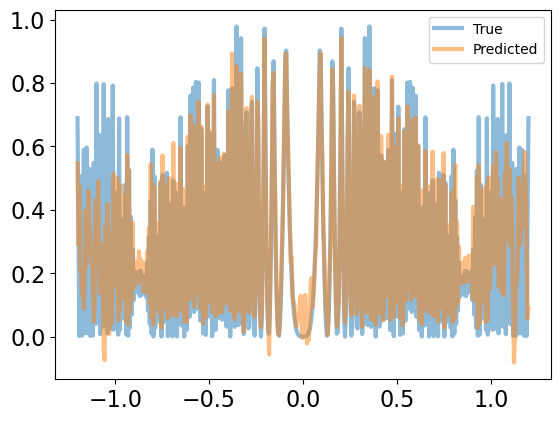

In [39]:
y_pred = model_uq.predict(x_val.unsqueeze(1))
plt.plot(x_val.cpu(), y_val.cpu(), label='True', alpha=0.5)
plt.plot(x_val.cpu(), y_pred, label='Predicted', alpha=0.5)
plt.legend()
plt.show()

In [40]:

pred_mean, pred_std, lower, upper = model_uq.compute_uncertainty(x_val.unsqueeze(1), n_samples=100)


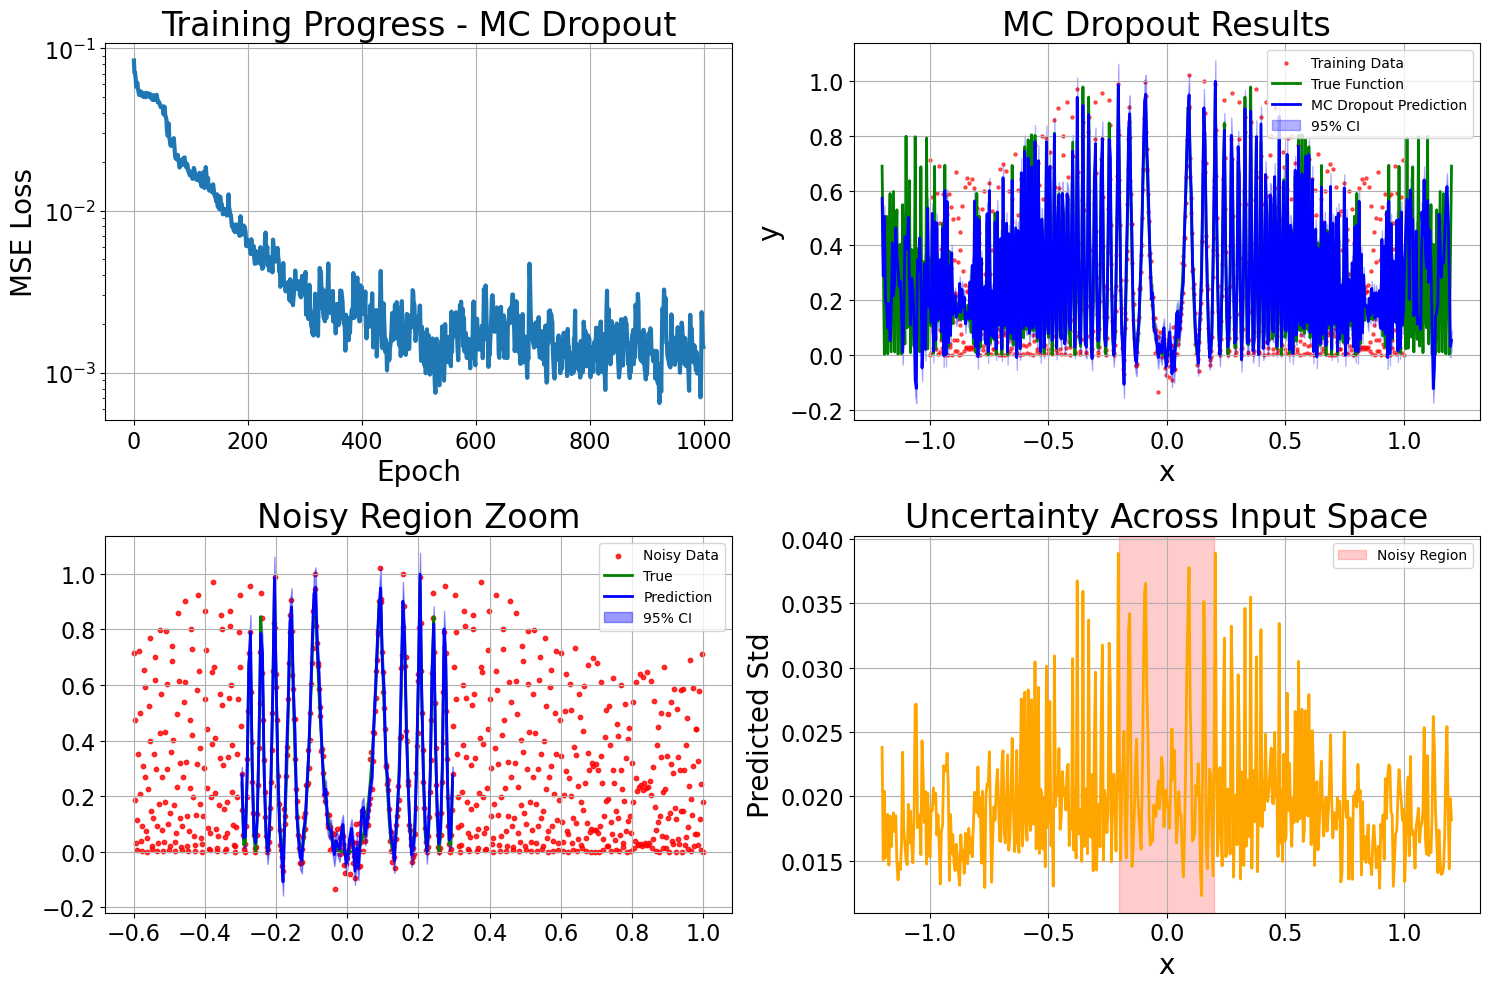

   MSE: 0.129374
   MAE: 0.281914
   Training Loss: 0.001445


In [41]:

# Move to CPU for plotting
x_val_cpu = x_val.cpu()
y_val_true_cpu = y_val.cpu()
pred_mean_cpu = pred_mean.squeeze()
pred_std_cpu = pred_std.squeeze()
x_train_cpu = x_train.cpu()
y_train_cpu = y_train.cpu()

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training progress
axes[0,0].plot(losses)
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('MSE Loss')
axes[0,0].set_title('Training Progress - MC Dropout')
axes[0,0].grid(True)
axes[0,0].set_yscale('log')

# Full predictions
axes[0,1].scatter(x_train_cpu, y_train_cpu, alpha=0.6, s=5, color='red', label='Training Data')
axes[0,1].plot(x_val_cpu, y_val_true_cpu, 'g-', linewidth=2, label='True Function')
axes[0,1].plot(x_val_cpu, pred_mean_cpu, 'blue', linewidth=2, label='MC Dropout Prediction')
axes[0,1].fill_between(x_val_cpu.squeeze(), 
                      pred_mean_cpu - 1.96*pred_std_cpu, 
                      pred_mean_cpu + 1.96*pred_std_cpu,
                      alpha=0.3, color='blue', label='95% CI')

axes[0,1].set_xlabel('x')
axes[0,1].set_ylabel('y')
axes[0,1].set_title('MC Dropout Results')
axes[0,1].legend()
axes[0,1].grid(True)

# Zoom on noisy region
mask = (x_val_cpu.squeeze() >= -0.3) & (x_val_cpu.squeeze() <= 0.3)
axes[1,0].scatter(x_train_cpu[200:], y_train_cpu[200:], alpha=0.8, s=10, color='red', label='Noisy Data')
axes[1,0].plot(x_val_cpu[mask], y_val_true_cpu[mask], 'g-', linewidth=2, label='True')
axes[1,0].plot(x_val_cpu[mask], pred_mean_cpu[mask], 'blue', linewidth=2, label='Prediction')
axes[1,0].fill_between(x_val_cpu[mask].squeeze(), 
                      (pred_mean_cpu - 1.96*pred_std_cpu)[mask], 
                      (pred_mean_cpu + 1.96*pred_std_cpu)[mask],
                      alpha=0.4, color='blue', label='95% CI')
axes[1,0].set_title('Noisy Region Zoom')
axes[1,0].legend()
axes[1,0].grid(True)

# Uncertainty plot
axes[1,1].plot(x_val_cpu, pred_std_cpu, 'orange', linewidth=2)
axes[1,1].axvspan(-0.2, 0.2, alpha=0.2, color='red', label='Noisy Region')
axes[1,1].set_xlabel('x')
axes[1,1].set_ylabel('Predicted Std')
axes[1,1].set_title('Uncertainty Across Input Space')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# Performance metrics
mse = np.mean((pred_mean - y_val.detach().cpu().numpy())**2)
mae = np.mean(np.abs(pred_mean - y_val.detach().cpu().numpy()))


print(f"   MSE: {mse:.6f}")
print(f"   MAE: {mae:.6f}")
print(f"   Training Loss: {losses[-1]:.6f}")


In [30]:
class MMNN_BNN(nn.Module):
    def __init__(self, 
                 ranks=[1] + [16]*5 + [1], 
                 widths=[366]*6,
                 device="cpu",
                 prior_var=0.1,
                 ResNet=False,
                 variance_strategy="uniform",
                 n_bayesian_layers=None,
                 activation_fn = SinTu):  # New parameter
        super().__init__()
        """
        MMNN_BNN: Bayesian Neural Network using MMNN structure with selective Bayesian layers
        
        Args:
            ranks: Output dimensions per layer [input_dim, ..., output_dim]
            widths: Width (number of basis functions) per layer
            device: Computing device
            prior_var: Prior variance for BNN layers
            ResNet: Whether to use residual connections
            variance_strategy: "uniform", "decreasing", "increasing", or "xavier"
            n_bayesian_layers: Number of W,b layers to make Bayesian (from last to first)
                              If None, all W,b layers are Bayesian (original behavior)
                              If 0, no layers are Bayesian (deterministic MMNN)
                              If k, the last k W,b layers are Bayesian
        """
        self.ranks = ranks
        self.widths = widths
        self.ResNet = ResNet
        self.depth = len(widths)
        self.device = device
        self.prior_var = prior_var
        self.variance_strategy = variance_strategy
        self.activation_fn = activation_fn()  # Activation function   
        # Determine which layers should be Bayesian
        self.n_bayesian_layers = n_bayesian_layers
        if self.n_bayesian_layers is None:
            self.n_bayesian_layers = self.depth  # All layers Bayesian (original behavior)
        
        # Validate n_bayesian_layers
        if self.n_bayesian_layers < 0 or self.n_bayesian_layers > self.depth:
            raise ValueError(f"n_bayesian_layers must be between 0 and {self.depth}, got {self.n_bayesian_layers}")
        
        print(f"MMNN_BNN Configuration:")
        print(f"  Total W,b layers: {self.depth}")
        print(f"  Bayesian W,b layers: {self.n_bayesian_layers}")
        if self.n_bayesian_layers > 0:
            bayesian_layer_indices = list(range(self.depth - self.n_bayesian_layers, self.depth))
            print(f"  Bayesian layer indices: {bayesian_layer_indices}")
        
        # Build layer sizes: [rank1, width1, rank2, width2, rank3, ..., rankn-1,withn-1, rank n]
        fc_sizes = [ranks[0]]
        for j in range(self.depth):
            fc_sizes += [widths[j], ranks[j+1]]
        
        # Initialize layers
        self.fcs = nn.ModuleList()
        self.bnn_params = nn.ParameterDict()  # BNN variance parameters
        
        for j in range(len(fc_sizes)-1):
            fc = nn.Linear(fc_sizes[j], fc_sizes[j+1], device=device)
            self.fcs.append(fc)
            
            # For W,b layers (even indices): Check if this layer should be Bayesian
            if j % 2 == 0:
                layer_idx = j // 2  # True layer index (0, 1, 2, ...)
                
                # Determine if this layer should be Bayesian
                # Bayesian layers start from the end: last n_bayesian_layers
                is_bayesian = layer_idx >= (self.depth - self.n_bayesian_layers)

                # Freeze the mean parameters (W, b)
                fc.weight.requires_grad = False
                fc.bias.requires_grad = False
                
                if is_bayesian:
                    print(f"  Making layer {layer_idx} (linear layer {j}) Bayesian")
                    
                    
                    
                    # Store fixed means
                    self.register_buffer(f'W_mean_{j}', fc.weight.clone())
                    self.register_buffer(f'b_mean_{j}', fc.bias.clone())
                    
                    # Calculate layer-specific prior variance
                    n_in = fc_sizes[j]
                    n_out = fc_sizes[j+1]
                    
                    weight_prior_var, bias_prior_var = self.get_layer_prior_var(
                        layer_idx, n_in, n_out, self.prior_var
                    )
                    
                    print(f"    W_var={weight_prior_var:.6f}, b_var={bias_prior_var:.6f}")
                    
                    # Initialize variance parameters (log-parameterization for stability)
                    self.bnn_params[f'W_log_var_{j}'] = nn.Parameter(
                        torch.full_like(fc.weight, math.log(weight_prior_var))
                    ).to(device)
                    self.bnn_params[f'b_log_var_{j}'] = nn.Parameter(
                        torch.full_like(fc.bias, math.log(bias_prior_var))
                    ).to(device)
                    
                    # Mark this layer as Bayesian for later reference
                    self.register_buffer(f'is_bayesian_{j}', torch.tensor(True))
                else:
                    print(f"  Keeping layer {layer_idx} (linear layer {j}) deterministic")
                    # Mark this layer as deterministic
                    self.register_buffer(f'is_bayesian_{j}', torch.tensor(False))

    def get_layer_prior_var(self, layer_idx, n_in, n_out, base_var=0.1):
        """
        Calculate layer-specific prior variance with multiple strategies
        
        Args:
            layer_idx: True MMNN layer index (0, 1, 2, ...)
            n_in: Input dimension
            n_out: Output dimension  
            base_var: Base variance scale
        
        Returns:
            weight_prior_var, bias_prior_var
        """
        if self.variance_strategy == "uniform":
            # Same variance for all layers
            weight_var = base_var / n_in  # Standard scaling
            bias_var = base_var#/n_in
            
        elif self.variance_strategy == "xavier":
            # Xavier/Glorot-style initialization for Bayesian setting
            weight_var = 2.0*base_var / (n_in + n_out)
            bias_var = 1.0 *base_var#/ n_out
            
        elif self.variance_strategy == "decreasing":
            # Earlier layers have higher variance (more uncertainty in basis functions)
            depth_factor = (self.depth - layer_idx) / self.depth
            weight_var = base_var * depth_factor / n_in
            bias_var = base_var * depth_factor#/n_in
            
        elif self.variance_strategy == "increasing":
            # Later layers have higher variance (more uncertainty in combinations)
            depth_factor = (layer_idx + 1) / self.depth
            weight_var = base_var * depth_factor / n_in
            bias_var = base_var * depth_factor#/n_in
            
        else:
            raise ValueError(f"Unknown variance strategy: {self.variance_strategy}")
        
        return weight_var, bias_var

    def is_layer_bayesian(self, layer_linear_idx):
        """Check if a linear layer index is Bayesian"""
        return getattr(self, f'is_bayesian_{layer_linear_idx}').item()

    def sample_bnn_params(self):
        """Sample W,b parameters from variational posterior (only for Bayesian layers)"""
        sampled_params = {}
        
        for name, param in self.bnn_params.items():
            if 'W_log_var' in name:
                layer_idx = name.split('_')[-1]
                
                # Get mean and variance
                W_mean = getattr(self, f'W_mean_{layer_idx}')
                W_var = torch.exp(param)  # Convert from log-variance
                
                # Sample using reparameterization trick
                eps = torch.randn_like(W_mean, device=W_mean.device)
                W_sample = W_mean + torch.sqrt(W_var) * eps
                sampled_params[f'W_{layer_idx}'] = W_sample
                
            elif 'b_log_var' in name:
                layer_idx = name.split('_')[-1]
                
                b_mean = getattr(self, f'b_mean_{layer_idx}')
                b_var = torch.exp(param)
                
                eps = torch.randn_like(b_mean, device=b_mean.device)
                b_sample = b_mean + torch.sqrt(b_var) * eps
                sampled_params[f'b_{layer_idx}'] = b_sample
        
        return sampled_params
    
    def forward(self, x, n_samples=1):
        """
        Forward pass with Monte Carlo sampling
        
        Args:
            x: Input tensor
            n_samples: Number of MC samples for inference
        
        Returns:
            output: Mean prediction (if n_samples=1) or samples
        """
        if n_samples == 1:
            return self._forward_single(x)
        else:
            return self._forward_mc(x, n_samples)
    
    def _forward_single(self, x):
        """Single forward pass for training"""
        sampled_params = self.sample_bnn_params()
        
        for j in range(self.depth):
            if self.ResNet and 0 < j < self.depth-1:
                x_id = x.clone()
            
            # W,b layer - check if Bayesian or deterministic
            layer_idx = 2 * j
            
            if self.is_layer_bayesian(layer_idx) and f'W_{layer_idx}' in sampled_params:
                # Use Bayesian sampled parameters
                W = sampled_params[f'W_{layer_idx}']
                b = sampled_params[f'b_{layer_idx}']
                x = F.linear(x, W, b)
            else:
                # Use deterministic parameters
                x = self.fcs[layer_idx](x)
            
            # x = torch.relu(x)
            x = self.activation_fn(x)  # Use the specified activation function
            
            # Deterministic A layer (always deterministic)
            x = self.fcs[layer_idx + 1](x)
            
            # ResNet connection
            if self.ResNet and 0 < j < self.depth-1:
                n = min(x.shape[1], x_id.shape[1])
                x[:, :n] = x[:, :n] + x_id[:, :n]
        
        return x
    
    def _forward_mc(self, x, n_samples):
        """Multiple forward passes for uncertainty estimation"""
        outputs = []
        for _ in range(n_samples):
            outputs.append(self._forward_single(x))
        return torch.stack(outputs, dim=0)  # [n_samples, batch_size, output_dim]
    
    def kl_divergence(self):
        """Compute KL divergence between posterior and prior (only for Bayesian layers)"""
        kl_div = 0.0
        
        for name, log_var_param in self.bnn_params.items():
            if 'W_log_var' in name:
                layer_idx_str = name.split('_')[-1]
                layer_idx_int = int(layer_idx_str)
                layer_idx = layer_idx_int // 2  # Convert to true layer index
                
                # Get layer dimensions
                n_in = self.fcs[layer_idx_int].in_features
                n_out = self.fcs[layer_idx_int].out_features
                
                # Get prior variance for this layer
                weight_prior_var, _ = self.get_layer_prior_var(layer_idx, n_in, n_out, self.prior_var)
                prior_log_var = math.log(weight_prior_var)
                
            elif 'b_log_var' in name:
                layer_idx_str = name.split('_')[-1]
                layer_idx_int = int(layer_idx_str)
                layer_idx = layer_idx_int // 2
                
                n_in = self.fcs[layer_idx_int].in_features
                n_out = self.fcs[layer_idx_int].out_features
                
                _, bias_prior_var = self.get_layer_prior_var(layer_idx, n_in, n_out, self.prior_var)
                prior_log_var = math.log(bias_prior_var)
            
            # KL[N(μ, σ²) || N(μ, σ_p²)] = 1/2 * [log(σ_p²/σ²) + σ²/σ_p² - 1]
            posterior_var = torch.exp(log_var_param)
            prior_var = math.exp(prior_log_var)
            
            kl_layer = 0.5 * (
                prior_log_var - log_var_param + 
                posterior_var / prior_var - 1.0
            )
            kl_div += kl_layer.sum()
        
        return kl_div
    
    def elbo_loss(self, x, y, n_samples=1, beta=1.0):
        """
        Compute ELBO loss for training
        
        Args:
            x, y: Input and target
            n_samples: MC samples for likelihood estimation
            beta: KL weighting (β-VAE style)
        """
        # Likelihood term: E_q[log p(y|x,θ)]
        if n_samples == 1:
            y_pred = self._forward_single(x)
            log_likelihood = -0.5 * F.mse_loss(y_pred, y, reduction='sum')
        else:
            y_samples = self._forward_mc(x, n_samples)  # [n_samples, batch, output]
            log_likelihood = 0.0
            for i in range(n_samples):
                log_likelihood += -0.5 * F.mse_loss(y_samples[i], y, reduction='sum')
            log_likelihood /= n_samples
        
        # KL term: KL[q(θ)||p(θ)] (only for Bayesian layers)
        kl_div = self.kl_divergence()
        
        # ELBO = E[log p(y|x,θ)] - β * KL[q(θ)||p(θ)]
        elbo = log_likelihood - beta * kl_div
        
        # Return negative ELBO for minimization
        return -elbo, log_likelihood, kl_div
    
    def l2_loss(self, x, y):
        """Compute L2 loss for regression tasks"""
        y_pred = self._forward_single(x)
        return F.mse_loss(y_pred, y, reduction='mean')

    def predict_with_uncertainty(self, x, n_samples=100):
        """Get predictive mean and uncertainty"""
        with torch.no_grad():
            samples = self._forward_mc(x, n_samples)  # [n_samples, batch, output]
            
            pred_mean = samples.mean(dim=0)
            pred_var = samples.var(dim=0)
            epistemic_uncertainty = pred_var.mean(dim=-1)  # Average over output dims
            
            return pred_mean, pred_var, epistemic_uncertainty
    
    def get_bayesian_layer_info(self):
        """Get information about which layers are Bayesian"""
        info = {
            'total_layers': self.depth,
            'bayesian_layers': self.n_bayesian_layers,
            'bayesian_layer_indices': [],
            'deterministic_layer_indices': []
        }
        
        for j in range(0, len(self.fcs), 2):  # Only W,b layers (even indices)
            layer_idx = j // 2
            if self.is_layer_bayesian(j):
                info['bayesian_layer_indices'].append(layer_idx)
            else:
                info['deterministic_layer_indices'].append(layer_idx)
        
        return info
    
    def count_parameters(self):
        """Count total, trainable, and Bayesian parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        bayesian_params = sum(p.numel() for p in self.bnn_params.values())
        
        # Count deterministic trainable parameters (A, c layers)
        deterministic_trainable = 0
        for j in range(1, len(self.fcs), 2):  # A layers (odd indices)
            deterministic_trainable += sum(p.numel() for p in self.fcs[j].parameters() if p.requires_grad)
        
        return {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'bayesian_parameters': bayesian_params,
            'deterministic_trainable_parameters': deterministic_trainable,
            'frozen_parameters': total_params - trainable_params
        }

In [ ]:
def evaluate_mmnn_bnn(model, data_loader, device, n_mc_samples=50):
    """
    Evaluate MMNN_BNN with uncertainty quantification
    
    Args:
        model: Trained MMNN_BNN
        data_loader: Data loader for evaluation
        device: Computing device
        n_mc_samples: MC samples for uncertainty estimation
    
    Returns:
        metrics: Dictionary of evaluation metrics
    """
    model.eval()
    
    all_targets = []
    all_means = []
    all_stds = []
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Monte Carlo sampling for uncertainty
            mc_samples = model._forward_mc(batch_x, n_mc_samples)  # [n_samples, batch, output]
            
            # Compute statistics
            pred_mean = mc_samples.mean(dim=0)  # [batch, output]
            pred_std = mc_samples.std(dim=0)    # [batch, output]
            
            # Accumulate for metrics
            all_targets.append(batch_y.cpu())
            all_means.append(pred_mean.cpu())
            all_stds.append(pred_std.cpu())
            
            # Loss computation
            loss, _, _ = model.elbo_loss(batch_x, batch_y, n_samples=1, beta=1.0)
            total_loss += loss.item()
            num_batches += 1
    
    # Concatenate all predictions
    targets = torch.cat(all_targets, dim=0)  # [total_samples, output_dim]
    means = torch.cat(all_means, dim=0)
    stds = torch.cat(all_stds, dim=0)
    
    # Compute metrics
    metrics = {}
    
    # Predictive performance
    metrics['loss'] = total_loss / num_batches
    metrics['rmse'] = torch.sqrt(torch.mean((targets - means)**2)).item()
    metrics['mae'] = torch.mean(torch.abs(targets - means)).item()
    
    # Uncertainty calibration
    errors = torch.abs(targets - means)
    
    # Coverage probabilities (assuming Gaussian predictive distribution)
    z_scores = errors / (stds + 1e-8)  # Avoid division by zero
    
    # 68% coverage (±1σ)
    metrics['coverage_68'] = (z_scores <= 1.0).float().mean().item()
    
    # 95% coverage (±1.96σ)  
    metrics['coverage_95'] = (z_scores <= 1.96).float().mean().item()
    
    # Average prediction interval width
    metrics['avg_uncertainty'] = stds.mean().item()
    
    # Calibration: correlation between predicted uncertainty and actual error
    if stds.numel() > 1:
        correlation = torch.corrcoef(torch.stack([stds.flatten(), errors.flatten()]))[0,1]
        metrics['uncertainty_correlation'] = correlation.item() if not torch.isnan(correlation) else 0.0
    else:
        metrics['uncertainty_correlation'] = 0.0
    
    return metrics



In [ ]:
def train_mmnn_bnn(model, train_loader, val_loader=None, 
                   epochs=1000, lr=1e-3, beta_schedule=None, 
                   n_mc_samples=1, device='cpu'):
    """
    Training scheme for MMNN_BNN
    
    Args:
        model: MMNN_BNN instance
        train_loader: Training data loader
        val_loader: Validation data loader (optional)
        epochs: Number of training epochs
        lr: Learning rate
        beta_schedule: Function for KL annealing (epoch -> beta)
        n_mc_samples: MC samples during training (1 for efficiency)
        device: Computing device
    """
    
    # Optimizer - separate learning rates for different parameter types
    bnn_params = list(model.bnn_params.parameters())
    bnn_param_ids = {id(p) for p in bnn_params}
    mlp_params = [p for p in model.parameters() if p.requires_grad and id(p) not in bnn_param_ids]
    
    optimizer = optim.Adam([
        {'params': bnn_params, 'lr': lr//5, 'name': 'bnn'},
        {'params': mlp_params, 'lr': lr , 'name': 'mlp'}
    ])
    
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)  
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=600, gamma=0.9)
    
    # Default beta schedule: gradual annealing from 0 to 1
    if beta_schedule is None:
        beta_schedule = lambda epoch: min(1.0, epoch / (epochs /200))
    
    # Training history
    history = {
        'train_loss': [], 'train_likelihood': [], 'train_kl': [],
        'val_loss': [], 'val_rmse': [], 'val_coverage': []
    }
    
    model.train()
    pbar = trange(epochs, desc="Training MMNN_BNN")
    
    for epoch in pbar:
        # Current beta for KL annealing
        beta = beta_schedule(epoch)
        
        # Training phase
        epoch_loss, epoch_likelihood, epoch_kl = 0.0, 0.0, 0.0
        num_batches = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            if model.n_bayesian_layers > 0:
                # Compute ELBO loss
                loss, likelihood, kl_div = model.elbo_loss(
                    batch_x, batch_y, n_samples=n_mc_samples, beta=beta
                )
            else:
                # Compute L2 loss for deterministic MMNN
                loss = model.l2_loss(batch_x, batch_y)
                likelihood = torch.tensor(0.0, device=device)  # No likelihood term
                kl_div = torch.tensor(0.0, device=device)  # No KL divergence
                # likelihood = -loss
            # Backward pass
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Accumulate metrics
            epoch_loss += loss.item()
            
            epoch_likelihood += likelihood.item()
            
            epoch_kl += kl_div.item()
            num_batches += 1
        
        # Average training metrics
        avg_loss = epoch_loss / num_batches
        avg_likelihood = epoch_likelihood / num_batches
        avg_kl = epoch_kl / num_batches
        
        history['train_loss'].append(avg_loss)
        history['train_likelihood'].append(avg_likelihood)
        history['train_kl'].append(avg_kl)
        
        # Validation phase
        val_metrics = {}
        if val_loader is not None:
            val_metrics = evaluate_mmnn_bnn(model, val_loader, device)
            history['val_loss'].append(val_metrics['loss'])
            history['val_rmse'].append(val_metrics['rmse'])
            history['val_coverage'].append(val_metrics['coverage_95'])
            
            scheduler.step()
        
        # Update progress bar
        pbar_dict = {
            'loss': f"{avg_loss:.3e}",
            'likelihood': f"{avg_likelihood:.3e}", 
            'kl': f"{avg_kl:.3e}",
            'beta': f"{beta:.3f}"
        }
        if val_metrics:
            pbar_dict.update({
                'val_rmse': f"{val_metrics['rmse']:.3e}",
                'val_cov': f"{val_metrics['coverage_95']:.2f}"
            })
        
        pbar.set_postfix(pbar_dict)

        if epoch %500 == 0:

            with torch.no_grad():
                x_test = torch.linspace(-1., 1., 1000).unsqueeze(1).to(device)
                preds = model._forward_mc(x_test, 100)
                pred_mean = preds.mean(dim=0)
                pred_std = preds.std(dim=0)
                lower = pred_mean - 1.96 * pred_std
                upper = pred_mean + 1.96 * pred_std
                plt.figure(figsize=(12, 4))
                plt.plot(x_test.cpu().flatten(), func(x_test.cpu().flatten()),'r-',linewidth = 0.5, label='True')
                plt.plot(x_test.cpu().flatten(), pred_mean.flatten().detach().cpu().numpy(), 'b-', label='Prediction')
                plt.fill_between(x_test.cpu().flatten(), lower.flatten().detach().cpu().numpy(), upper.flatten().detach().cpu().numpy(), 
                        alpha=0.3, label='95% CI')
                plt.title(f"Epoch {epoch} - ELBO: {avg_loss:.3e}, KL: {avg_kl:.3e}, Beta: {beta:.3f}")
                plt.show()
        
        # Early stopping on KL explosion
        if avg_kl > 1e6:
            print(f"Training stopped at epoch {epoch}: KL divergence exploded")
            break
    
    return history

In [ ]:
def predict_with_uncertainty(model, x, n_samples=100, confidence_level=0.95):
    """
    Make predictions with uncertainty intervals
    
    Args:
        model: Trained MMNN_BNN
        x: Input tensor
        n_samples: MC samples for uncertainty
        confidence_level: Confidence level for intervals
        
    Returns:
        mean: Predictive mean
        std: Predictive standard deviation  
        lower: Lower confidence bound
        upper: Upper confidence bound
    """
    model.eval()
    
    with torch.no_grad():
        # Monte Carlo sampling
        samples = model._forward_mc(x, n_samples)  # [n_samples, batch, output]
        
        # Compute statistics
        mean = samples.mean(dim=0)
        std = samples.std(dim=0)
        
        # Confidence intervals (assuming Gaussian)
        from scipy.stats import norm
        z_score = norm.ppf((1 + confidence_level) / 2)
        
        lower = mean - z_score * std
        upper = mean + z_score * std
        
    return mean, std, lower, upper



In [ ]:



def test_mmnn_bnn_integration(model,n_epochs=10_000,lr = 1e-3,device  = 'cpu'):
    # Generate data
    torch.manual_seed(42)
    x_train_no_noise = torch.cat([
        torch.linspace(-1, -0.2, 400).unsqueeze(1),
        torch.linspace(0.2, 1, 400).unsqueeze(1)
    ]).to(device)
    y_train_no_noise = func(x_train_no_noise) + 0.0 * torch.randn_like(x_train_no_noise)


    x_train_noise = torch.linspace(-.2,.2, 200).unsqueeze(1).to(device)
    y_train_noise = func(x_train_noise) + 0.15 * torch.randn_like(x_train_noise)    
    
    x_train = torch.cat([x_train_no_noise, x_train_noise], dim=0).to(device)
    y_train = torch.cat([y_train_no_noise, y_train_noise], dim=0).to(device)

    plt.scatter(x_train.cpu(), y_train.cpu(), alpha=0.6, s=20, label='Train')
    plt.show()
    
    x_val = torch.linspace(-1.2, 1.2, 50).unsqueeze(1).to(device)
    # y_val = func(2 * np.pi * x_val) + 0.000 * torch.randn_like(x_val)
    y_val = func(x_val) + 0.0 * torch.randn_like(x_val)
    
    # Data loaders
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=100)
    
    # Create model
    
    
    
    
    # Train
    print("Testing MMNN_BNN training...")
    history = train_mmnn_bnn(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=n_epochs,
        lr=lr,
        beta_schedule=lambda epoch: min(1.0, epoch / 1000),
        n_mc_samples=1,
        device=device
    )
    
    # Test prediction
    print("Testing uncertainty prediction...")
    x_test = torch.linspace(-1, 1., 1000).unsqueeze(1).to(device)
    
    mean, std, lower, upper = predict_with_uncertainty(
        model, x_test, n_samples=50, confidence_level=0.90
    )
    
    # Plot
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    if history['val_loss']:
        plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Progress')
    
    plt.subplot(1, 2, 2)
    plt.scatter(x_train.cpu(), y_train.cpu(), alpha=0.6, s=10, label='Train')
    # plt.plot(x_test, func(2 * np.pi * x_test), 'r-', label='True')
    plt.plot(x_test.cpu(), func(x_test).cpu(), 'r-',linewidth = 0.5, label='True')
    plt.plot(x_test.cpu(), mean.detach().cpu(), 'b-', label='Prediction')
    plt.fill_between(x_test.cpu().flatten(), lower.flatten().detach().cpu(), upper.flatten().detach().cpu(), 
                     alpha=0.3, label='95% CI')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Predictions with Uncertainty')
    
    plt.tight_layout()
    plt.show()
    
    # Check if working
    final_loss = history['train_loss'][-1]
    coverage = history['val_coverage'][-1] if history['val_coverage'] else 0.5
    
    print(f"\nTest Results:")
    print(f"Final loss: {final_loss:.3f}")
    print(f"Val coverage: {coverage:.3f}")
    print(f"Expected coverage: ~0.95")
    
    success = (final_loss < 1000) and (0.8 < coverage < 1.0)
    print(f"Test {'PASSED' if success else 'FAILED'}")
    
    return model, history,(x_train, y_train)


    

In [ ]:
num_layers = 6
ranks = [1]+[36]*(num_layers-1)+[1]
widths = [2**8]*num_layers
prior_var = .01


model = MMNN_BNN(
        ranks= ranks,  # Example ranks
        widths=widths, 
        prior_var=prior_var,
        device=device,
        ResNet=False,
        n_bayesian_layers=1,
        variance_strategy="increasing"  # or "uniform", "increasing", "xavier"
    ).to(device)

MMNN_BNN Configuration:
  Total W,b layers: 6
  Bayesian W,b layers: 1
  Bayesian layer indices: [5]
  Keeping layer 0 (linear layer 0) deterministic
  Keeping layer 1 (linear layer 2) deterministic
  Keeping layer 2 (linear layer 4) deterministic
  Keeping layer 3 (linear layer 6) deterministic
  Keeping layer 4 (linear layer 8) deterministic
  Making layer 5 (linear layer 10) Bayesian
    W_var=0.000278, b_var=0.010000


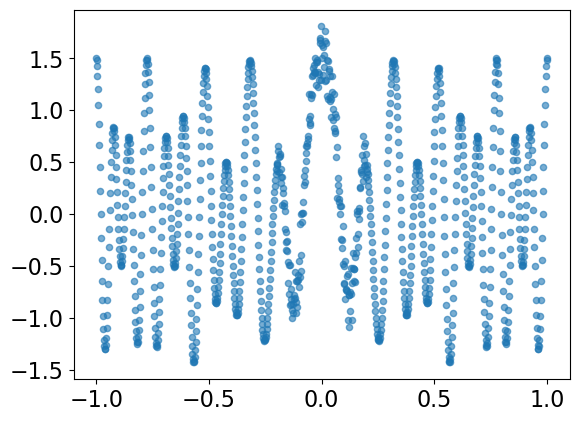

Testing MMNN_BNN training...


Training MMNN_BNN:   0%|          | 0/10000 [00:00<?, ?it/s, loss=3.280e+01, likelihood=-3.280e+01, kl=-2.747e-04, beta=0.000, val_rmse=8.902e-01, val_cov=0.06]

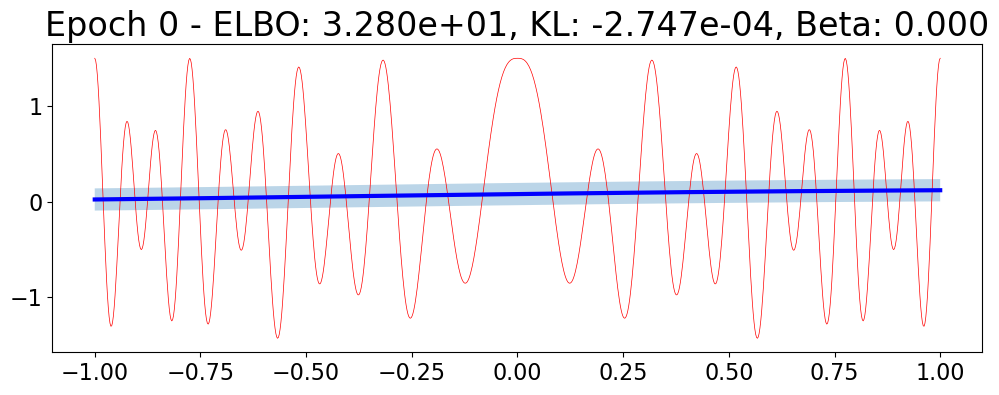

Training MMNN_BNN:   5%|▍         | 499/10000 [00:43<14:05, 11.24it/s, loss=1.946e+00, likelihood=-1.946e+00, kl=-2.747e-04, beta=0.500, val_rmse=5.696e-01, val_cov=0.48]

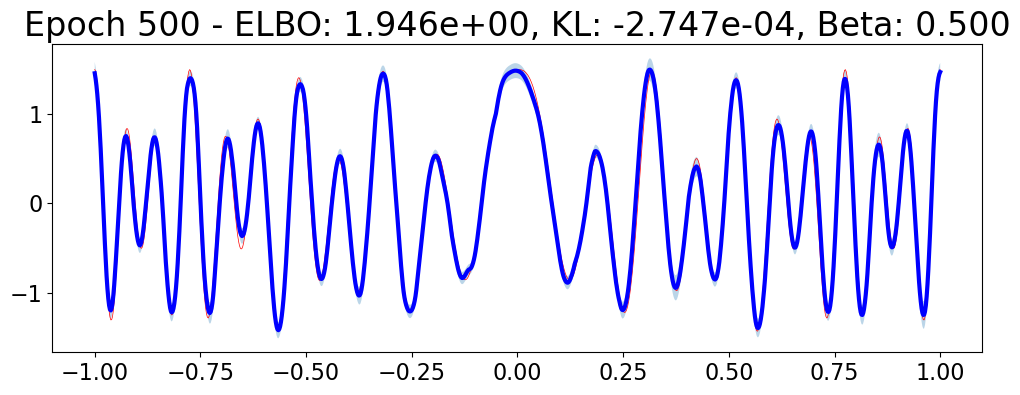

Training MMNN_BNN:  10%|▉         | 999/10000 [01:26<12:57, 11.58it/s, loss=1.136e+00, likelihood=-1.136e+00, kl=-2.747e-04, beta=1.000, val_rmse=5.086e-01, val_cov=0.44]

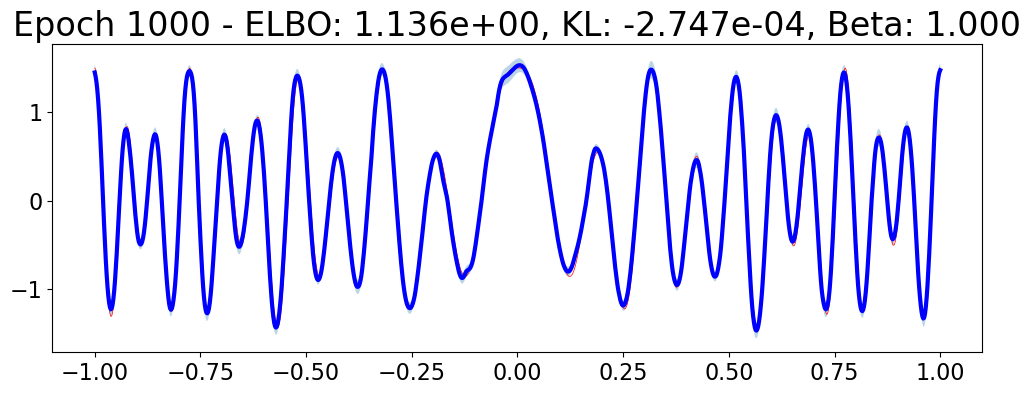

Training MMNN_BNN:  15%|█▍        | 1499/10000 [02:10<12:12, 11.60it/s, loss=7.015e-01, likelihood=-7.018e-01, kl=-2.747e-04, beta=1.000, val_rmse=4.341e-01, val_cov=0.58]

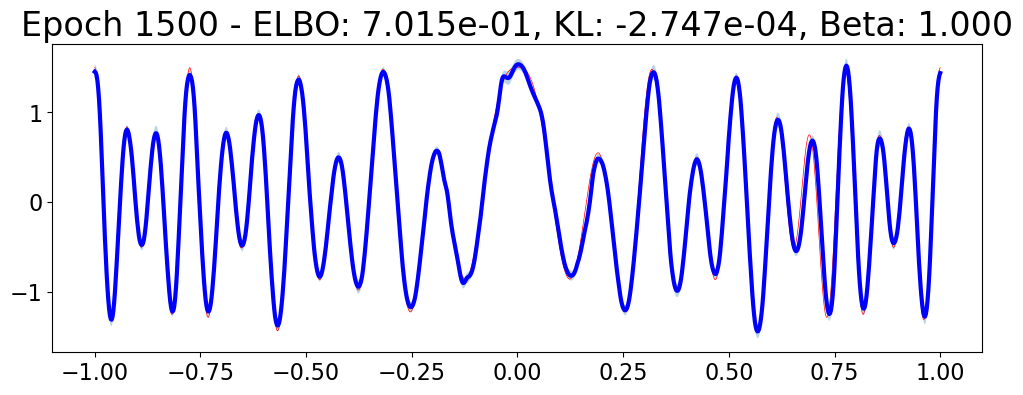

Training MMNN_BNN:  20%|█▉        | 1999/10000 [02:53<11:40, 11.42it/s, loss=6.194e-01, likelihood=-6.197e-01, kl=-2.747e-04, beta=1.000, val_rmse=4.459e-01, val_cov=0.32]

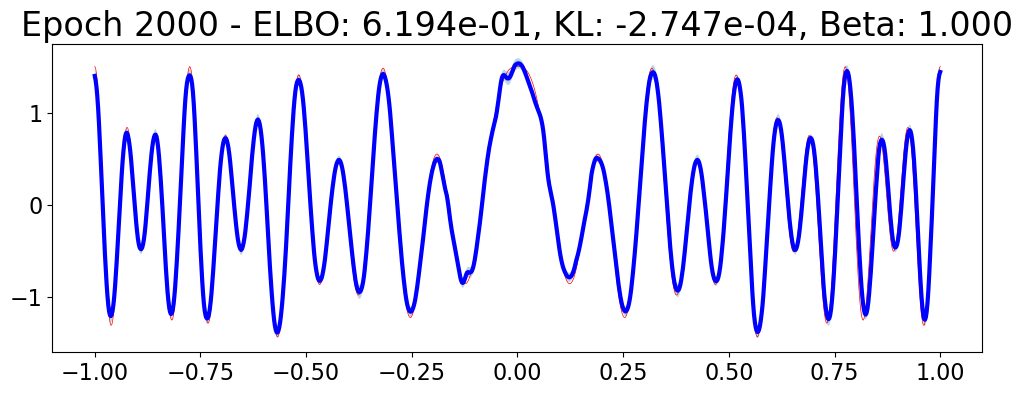

Training MMNN_BNN:  21%|██▏       | 2126/10000 [03:04<11:23, 11.51it/s, loss=5.245e-01, likelihood=-5.248e-01, kl=-2.747e-04, beta=1.000, val_rmse=4.324e-01, val_cov=0.58]


KeyboardInterrupt: 

In [ ]:

model, history, (x_train, y_train) = test_mmnn_bnn_integration(model,n_epochs=10000,lr = 1e-3,device=device)

In [ ]:
# Test prediction
print("Testing uncertainty prediction...")
x_test = torch.linspace(-1.2, 1.2, 2000).unsqueeze(1).to(device)

mean, std, lower, upper = predict_with_uncertainty(
    model, x_test, n_samples=50, confidence_level=0.95
)

# Plot
plt.figure(figsize=(12, 4))


plt.plot(x_train.cpu(), y_train.cpu() ,'r*',markersize = 0.5, label='Training Data')
plt.plot(x_test.cpu(), mean.detach().cpu(), 'b-', label='Prediction')
plt.fill_between(x_test.cpu().flatten(), lower.flatten().detach().cpu(), upper.flatten().detach().cpu(), 
                    alpha=0.6, label='95% CI')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Predictions with Uncertainty')

plt.tight_layout()
plt.show()




In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(x_test.cpu(), func(x_test).cpu(), 'r*',markersize = 0.5, label='True')
plt.plot(x_test.cpu(), model._forward_single(x_test).flatten().detach().cpu().numpy(), 'b-', label='Deterministic Prediction' )
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Deterministic Predictions')